In [5]:
import math
from scipy.stats import wilcoxon
from scipy.stats import binom_test

In [6]:
dat = pd.read_csv("../results/all.txt", compression="gzip", sep="\t", header=None)
dat.columns = ["branch", "kind", "number", "chunk", "motif", "og_motif"]
dat["length"] = [int(c.split(":")[1].split("-")[1])-int(c.split(":")[1].split("-")[0]) for c in dat.chunk]
dat = dat[dat.length>1e6]

In [7]:
pos_motifs = dat.motif.unique()

In [8]:
dat = dat[dat.groupby(["chunk", "motif"])["number"].transform(lambda x: ~(x==0).all())].reset_index(drop=True)

In [9]:
results = dat.groupby(["motif", "branch", "kind"])["number"].sum().reset_index()
midpoint = results.pivot(index=["motif", "kind"], columns=["branch"]).reset_index()
midpoint.columns = ["motif", "kind", "Pantherophis_guttatus", "Pantherophis_obsoletus"]
midpoint["ratio"] = midpoint.Pantherophis_guttatus/midpoint.Pantherophis_obsoletus

In [10]:
midpoint = midpoint.groupby("motif").filter(lambda df: not any(math.isnan(x) or math.isinf(x) for x in df["ratio"].values))

In [11]:
og_results = midpoint[midpoint.motif.isin(dat.og_motif.unique())]

In [12]:
belong = dat.set_index("motif")["og_motif"].to_dict()
midpoint["og_motif"] = midpoint.motif.map(belong)

In [13]:
midpoint["nature"] = midpoint.motif == midpoint.og_motif

<Axes: xlabel='ratio', ylabel='motif'>

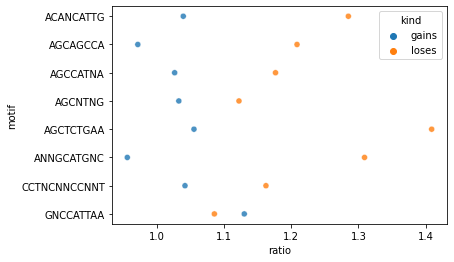

In [14]:
f,ax = plt.subplots()
sns.scatterplot(data=og_results, x="ratio", y="motif", hue="kind",ax=ax, alpha=0.8)

In [15]:
def safediv(n, d):
    return n/d if d>0 else np.nan

def get_cis(df):
    
    cdf = df[df.branch=="Pantherophis_guttatus"]
    rdf = df[df.branch=="Pantherophis_obsoletus"]
    
    ratio = safediv(cdf.number.sum(),rdf.number.sum())
    
    ratios = []
    for r in range(500):
        rcdf = cdf.sample(n=len(cdf), replace=True)
        rrdf = rdf.sample(n=len(rdf), replace=True)
        ratios.append(safediv(rcdf.number.sum(),rrdf.number.sum()))
        
    cis = pd.Series([np.percentile(ratios, 2.5), 
                     ratio,
                     np.percentile(ratios, 97.5)])
    cis.index = ["low_ratio", "ratio", "high_ratio"]
    
    return cis 

def get_cis(df):
    
    cdf = df[df.branch=="Pantherophis_guttatus"]
    rdf = df[df.branch=="Pantherophis_obsoletus"]
    
    ratio = safediv(cdf.number.sum(),rdf.number.sum())

    cchunks = list(cdf.chunk.unique())
    rchunks = list(rdf.chunk.unique())

    ccol = {chunk:d for chunk,d in cdf.groupby("chunk")}
    rcol = {chunk:d for chunk,d in rdf.groupby("chunk")}
    
    ratios = []
    for r in range(200):
        sel_chunks = np.random.choice(cchunks, size=len(cchunks))
        rcdf = pd.concat([ccol[c] for c in sel_chunks])
        rrdf = pd.concat([rcol[c] for c in sel_chunks])
        ratios.append(safediv(rcdf.number.sum(),rrdf.number.sum()))
        
    cis = pd.Series([np.percentile(ratios, 2.5), 
                     ratio,
                     np.percentile(ratios, 97.5)])
    cis.index = ["low_ratio", "ratio", "high_ratio"]
    
    return cis 

results = dat[dat.motif.isin(dat.og_motif.unique())].groupby(["motif", "kind"]).apply(get_cis).reset_index()

In [16]:
results = results.groupby("motif").filter(lambda df: not any(math.isnan(x) or math.isinf(x) for x in df["ratio"].values))

In [17]:
results["width"] = results.high_ratio-results.low_ratio

In [23]:
results.to_csv("../../../figures_final/data/Figure3a_Data.csv")

In [20]:
g, l = [], []
for motif,df in results.groupby("motif"):
    if len(df)==2:
        g.append(df[df.kind=="gains"].ratio.values[0])
        l.append(df[df.kind=="loses"].ratio.values[0])
        
print(wilcoxon(l, g, alternative="greater"))
print(sum([1 for gv,lv in zip(g, l) if lv>gv]), len(g))
print(binom_test(sum([1 for gv,lv in zip(g, l) if lv>gv]), len(g), 0.5, alternative='greater'))

WilcoxonResult(statistic=35.0, pvalue=0.0078125)
7 8
0.03515625


In [21]:
def check_overlap(interval1, interval2):

    interval1.sort()
    interval2.sort()

    if (interval1[1] >= interval2[0] and interval1[0] <= interval2[1]) or \
       (interval2[1] >= interval1[0] and interval2[0] <= interval1[1]):
        return True

    return False

def build_sign(df):
    if len(df)!=2:
        return np.nan
    gain = df[df.kind=="gains"]
    loss = df[df.kind=="loses"]
    igain = gain[["low_ratio", "high_ratio"]].values[0]
    iloss = loss[["low_ratio", "high_ratio"]].values[0]
    sign = check_overlap(igain, iloss)
    return pd.Series([sign])
    
#results.groupby("motif").apply(build_sign)

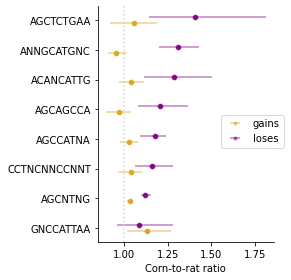

In [22]:
f, ax = plt.subplots(figsize=[4,4])

kinds = ["gains", "loses"]
colors = ["goldenrod", "purple"]
pad = [-0.1, 0.1]

subset = results[(results["kind"] == "loses")] 
morder = subset.sort_values(by="ratio").motif.values

for i,kind in enumerate(kinds):
    subset = results[(results["kind"] == kind)] 
    subset = subset.reset_index(drop=True) 
    subset = subset.set_index("motif").loc[morder].reset_index()
    subset["ycor"] = subset.index + pad[i]
    sns.scatterplot(data=subset, x="ratio", y="ycor", color=colors[i], ax=ax, alpha=0.9)
    lower_error = abs(subset["ratio"] - subset["low_ratio"])
    upper_error = abs(subset["high_ratio"] - subset["ratio"])
    asymmetric_error = [lower_error, upper_error]
    plt.errorbar(subset["ratio"], subset["ycor"], xerr=asymmetric_error, fmt='.', 
                 capsize=0, alpha=0.5, label=kind, color=colors[i])

ax.set_yticks(range(len(subset)))
ax.set_yticklabels(subset.motif)
#ax.set_xlim([0., 2])
ax.axvline(x=1, color="lightgray", linestyle="dotted")
ax.legend(loc=(0.7, 0.4))
sns.despine()
ax.set_ylabel("")
ax.set_xlabel("Corn-to-rat ratio")
plt.tight_layout()
#plt.savefig("gain_loss_ratio_new_p1.pdf")

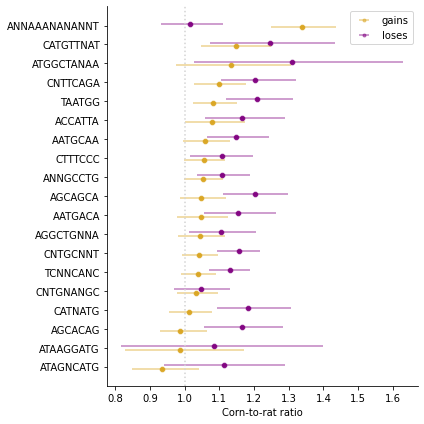

In [13]:
f, ax = plt.subplots(figsize=[6,6])

kinds = ["gains", "loses"]
colors = ["goldenrod", "purple"]
pad = [-0.1, 0.1]

for i,kind in enumerate(kinds):
    subset = results[(results["kind"] == kind) & (results.width<0.7) & (results.motif!="AACGGANCTG")]
    subset = subset.reset_index(drop=True) #set_index("motif").loc[morder].reset_index()
    if kind=="gains":
        morder = subset.sort_values(by="ratio").motif.values
    subset = subset.set_index("motif").loc[morder].reset_index()
    subset["ycor"] = subset.index + pad[i]
    sns.scatterplot(data=subset, x="ratio", y="ycor", color=colors[i], ax=ax, alpha=0.9)
    lower_error = abs(subset["ratio"] - subset["low_ratio"])
    upper_error = abs(subset["high_ratio"] - subset["ratio"])
    asymmetric_error = [lower_error, upper_error]
    plt.errorbar(subset["ratio"], subset["ycor"], xerr=asymmetric_error, fmt='.', 
                 capsize=0, alpha=0.5, label=kind, color=colors[i])

ax.set_yticks(range(len(subset)))
ax.set_yticklabels(subset.motif)
#ax.set_xlim([0.8, 2.1])
ax.axvline(x=1, color="lightgray", linestyle="dotted")
ax.legend()
sns.despine()
ax.set_ylabel("")
ax.set_xlabel("Corn-to-rat ratio")
plt.tight_layout()
#plt.savefig("gain_loss_ratio.pdf")

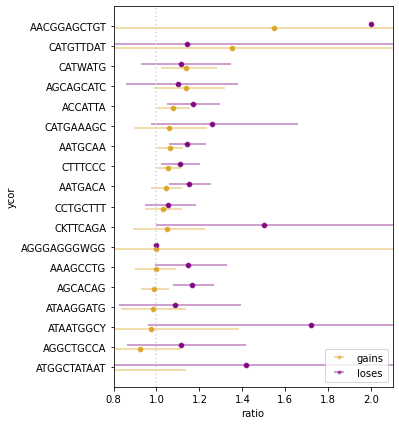

In [282]:
f, ax = plt.subplots(figsize=[5,7])

kinds = ["gains", "loses"]
colors = ["goldenrod", "purple"]
pad = [-0.1, 0.1]

for i,kind in enumerate(kinds):
    subset = results[results["kind"] == kind]
    subset = subset.set_index("motif").loc[morder].reset_index()
    subset["ycor"] = subset.index + pad[i]
    sns.scatterplot(data=subset, x="ratio", y="ycor", color=colors[i], ax=ax, alpha=0.9)
    lower_error = abs(subset["ratio"] - subset["low_ratio"])
    upper_error = abs(subset["high_ratio"] - subset["ratio"])
    asymmetric_error = [lower_error, upper_error]
    plt.errorbar(subset["ratio"], subset["ycor"], xerr=asymmetric_error, fmt='.', 
                 capsize=0, alpha=0.5, label=kind, color=colors[i])

ax.set_yticks(range(len(subset)))
ax.set_yticklabels(subset.motif)
ax.set_xlim([0.8, 2.1])
ax.axvline(x=1, color="lightgray", linestyle="dotted")
ax.legend()
plt.show()

In [198]:
reps = 500

l = []
for (motif,branch), df in dat.groupby(["motif", "branch", "kind"]):
    if motif not in motifs: continue
        
    #boots = [df.sample(n=len(df), replace=True).number.sum() for rep in range(reps)]
    #mean = np.mean(boots) #df.number.sum()
    #low = np.percentile(boots, 2.5)
    #high = np.percentile(boots, 97.5)
    #l.append([motif, kind, branch, low, mean, high])

#cis = pd.DataFrame(l)
#cis.columns = ["motif", "kind", "branch", "low", "mean", "high"]

In [199]:
results = cis.pivot(index=["motif", "kind"], columns=["branch"]).reset_index()
results.columns = ["_".join(cs) if cs[1]!="" else cs[0] for cs in results.columns]

In [200]:
results["ratio"] = results.mean_Pantherophis_guttatus/results.mean_Pantherophis_obsoletus
results["low_ratio"] = results.low_Pantherophis_guttatus/results.low_Pantherophis_obsoletus
results["high_ratio"] = results.high_Pantherophis_guttatus/results.high_Pantherophis_obsoletus

In [201]:
results = results.sort_values(by="ratio").reset_index()

In [202]:
morder = list(results[results.kind=="gains"].sort_values(by="ratio").motif)

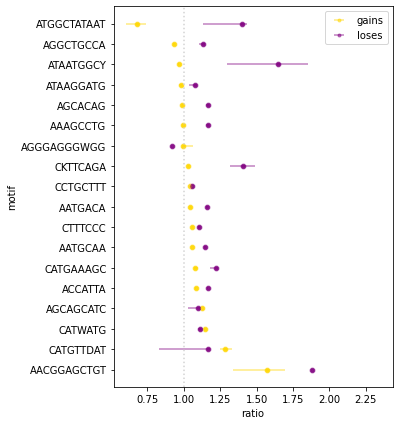

In [203]:
f, ax = plt.subplots(figsize=[5,7])

kinds = ["gains", "loses"]
colors = ["gold", "purple"]

for i,kind in enumerate(kinds):
    subset = results[results["kind"] == kind]
    subset = subset.set_index("motif").loc[morder].reset_index()
    sns.scatterplot(data=subset, x="ratio", y="motif", color=colors[i], ax=ax, alpha=0.8)
    lower_error = abs(subset["ratio"] - subset["low_ratio"])
    upper_error = abs(subset["high_ratio"] - subset["ratio"])
    asymmetric_error = [lower_error, upper_error]
    plt.errorbar(subset["ratio"], subset["motif"], xerr=asymmetric_error, fmt='.', 
                 capsize=0, alpha=0.5, label=kind, color=colors[i])

ax.axvline(x=1, color="lightgray", linestyle="dotted")
ax.legend()
plt.show()


<Axes: xlabel='ratio', ylabel='motif'>

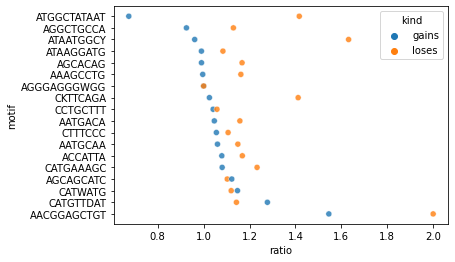

In [155]:
f,ax = plt.subplots()
sns.scatterplot(data=results, x="ratio", y="motif", hue="kind",ax=ax, alpha=0.8)

Distribution of matches

In [1]:
import sys
from optparse import OptionParser
from collections import Counter
from Bio import Seq
from Bio.SeqUtils import IUPACData
from Bio.SeqUtils import seq3
from Bio import motifs

In [5]:
def create_pwm(input_text):
    # Split the text into lines
    lines = input_text.strip().split("\n")

    # Get the line with the PWM values
    pwm_lines = lines[2:]

    # Create an empty count matrix
    counts = {'A': [], 'C': [], 'G': [], 'T': []}

    # Populate the count matrix with the PWM values
    for line in pwm_lines:
        a, c, g, t = map(float, line.split())
        counts['A'].append(a)
        counts['C'].append(c)
        counts['G'].append(g)
        counts['T'].append(t)

    # Create a motif object from the counts
    m = motifs.Motif(counts=counts)

    # Normalize the counts to get the PWM
    pwm = m.counts.normalize()

    return pwm

pwms = []
with open("../misc_files/streme_p05.txt", "r") as fh:
    texts = [""]
    for i,line in enumerate(fh):
        line0 = line.strip()
        if len(line0)==0:
            if i!=0:
                pwms.append(create_pwm(texts[-1]))
            texts.append("")
        else:
            texts[-1] += line

pwms.append(create_pwm(texts[-1]).log_odds())

In [9]:
pwms[0]

{'A': (0.780463,
  0.037575,
  0.01311301311301311,
  0.8453831546168453,
  0.045557,
  0.000133000133000133,
  0.977785,
  0.020933,
  0.00013299999999999998,
  0.8049091950908048,
  0.099819,
  0.023017000000000003,
  0.7772342227657774),
 'C': (0.022124,
  0.04268,
  0.9536469536469535,
  0.0031829968170031826,
  0.151039,
  0.8578338578338577,
  9e-05,
  0.310884,
  0.9977739999999998,
  8.999991000008999e-05,
  0.104341,
  0.5438900000000001,
  0.10065889934110067),
 'G': (0.138297,
  0.003699,
  9.000009000009e-05,
  0.13993386006613992,
  9e-05,
  0.004735004735004734,
  0.021992,
  0.00539,
  8.999999999999999e-05,
  0.16409483590516405,
  9e-05,
  0.13692900000000002,
  0.10866789133210868),
 'T': (0.059116,
  0.916046,
  0.03315003315003315,
  0.011499988500011498,
  0.803314,
  0.13729813729813728,
  0.000133,
  0.662793,
  0.0020029999999999996,
  0.0309059690940309,
  0.79575,
  0.29616400000000004,
  0.013438986561013439)}

In [29]:
def consense_pwm(pwm, th):
    n_pos = len(pwm["A"])
    nucs = ["A","C","G","T"]
    motif = ""
    for i in range(n_pos):
        probs = [pwm[n][i] for n in nucs]
        if max(probs)<th:
            motif += "N"
        else:
            motif += nucs[probs.index(max(probs))]

    return motif.lstrip("N").rstrip("N")


        
motifs = [consense_pwm(pwm, 0.85) for pwm in pwms]

In [44]:
def generate_mutations(dna_sequence):
    bases = ['A', 'C', 'G', 'T']
    mutations = []

    for i in range(len(dna_sequence)):
        if dna_sequence[i] != 'N':
            for base in bases:
                if dna_sequence[i] != base:
                    mutation = dna_sequence[:i] + base + dna_sequence[i+1:]
                    mutations.append(mutation)
    return mutations


with open(f"../misc_files/motifs_mutate.txt", "w") as oh:
    for motif in motifs:
        oh.write(f"{motif}_{motif}\n")
        for mut_motif in generate_mutations(motif):
            oh.write(f"{mut_motif}_{motif}\n")

In [408]:
def split_sequences(sequences):
    '''Splits sequences in dictionaries into chunks without any N'''

    result = {species: [[]] for species in sequences.keys()}
    sequence_length = len(next(iter(sequences.values())))

    for i in range(sequence_length):
        if any(sequence[i] == 'N' for sequence in sequences.values()):
            for species in sequences.keys():
                result[species].append([])
            continue
        for species, sequence in sequences.items():
            result[species][-1].append(sequence[i])

    for species in sequences.keys():
        result[species] = ["".join(subseq) for subseq in result[species] if subseq]

    return result

def read_maf(maf_file, species, ref, pwm):
    '''Returns dictionary of fasta sequences for each species in the MAF'''
    
    with open(maf_file,"r") as maf:

        skipNext = False
        compare = [sp for sp in species if sp!=ref]
        scores = {sp:[] for sp in species}
        motif_l = len(pwm["A"])
        
        for line in maf:
            line = line.strip()
            fields = line.split()    
            
            # Skip the single empty line after the header and before sequence blocks
            if skipNext:
                skipNext = False
                continue
            
            # Process the header, take the name of 'species' in the maf file
            if line.startswith("#"):
                if line.startswith("# hal"):
                    sequences = {sp:[] for sp in species}
                    tmp_sequences = {sp:"" for sp in species}
                    branches_seen = []
                    skipNext = True
                    
            # Process alignment lines, add to dictionary of sequences
            if line.startswith("s"):
                if fields[0]=="s":
                    branch = fields[1].split(".")[0]
                    if branch not in species: continue
                    dna = fields[-1].upper()
                    dna = dna.replace("-","N")
                    if branch==ref:
                        ref_chunk = fields[-1]
                    tmp_sequences[branch] += dna.upper()
                    branches_seen.append(branch)
                        
            # Only keep track of sequences if species were represented only once in previous block
            if line=="":
                branch_count = Counter(branches_seen)
                if len(branch_count)==len(species) and all(v==1 for k,v in branch_count.items()):
                    split_seqs = split_sequences(tmp_sequences)
                    n_seqs = len(split_seqs[ref])
                    if n_seqs==0: continue
                    for sp in split_seqs:
                        for dna in split_seqs[sp]:
                            if len(dna)-1<motif_l: continue
                            sc = pwm.calculate(dna)
                            scores[sp].extend(sc)

                tmp_sequences = {sp:"" for sp in species}
                branches_seen = []
    return scores

scores = read_maf("../test.maf", ["Pantherophis_guttatus","Pantherophis_obsoletus", "Thamnophis_elegans"], "Thamnophis_elegans", pwms[0])